In [40]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pandas.plotting import lag_plot
from datetime import datetime

In [41]:
def test_stationarity(timeseries):
        # DETERMINING ROLLING STATISTICS
        rolmean = timeseries.rolling(12).mean()
        rolstd = timeseries.rolling(12).std()
        adft = adfuller(timeseries, autolag = 'AIC')
        
        output = pd.Series(adft[0:4],index = ['test statistics','p-value','No. of lags used','Number of observations used'])
        for key,values in adft[4].items():
            output['critical value (%s)'%key] =  values

In [42]:
def info_graph(file, a, b, c, colorNum):
    
    # DATA 
    data = pd.read_csv(file)

    # FORMATTING THE DATE
    value = 0
    try:
        datetime.strptime(data['Date'][0], '%Y-%m-%d')
        value = 0
    except ValueError:
        value = 1
    if value == 1:
        data['Date'] = pd.to_datetime(data.Date,format = '%d-%m-%Y')
    else:
        data['Date'] = pd.to_datetime(data.Date,format = '%Y-%m-%d')
    data.index = data['Date']

    #SORTING IN ASCENDING ORDER
    data = data.sort_index(ascending = True, axis = 0)

    # NEW DATASET WITH THE NECESSARY COLUMN
    data_close = data['Close']
    pd.options.mode.chained_assignment = None

    # CHECKING IF STATIONARY
    test_stationarity(data_close)

    # LOG THE DATA
    data_log = np.log(data_close)
    pd.DataFrame(data_log)

    # DIVIDING TEST AND TRAIN CASES
    number = int(0.8*len(data['Close']))
    train = data_log[:number]
    test = data_log[number:]

    # MODEL
    model_autoARIMA = auto_arima(train, start_p = 0, start_q = 0,
                      test = 'adf',      
                      max_p = 3, max_q = 3, 
                      m = 1,              
                      d = None,          
                      seasonal = False,   
                      start_P = 0, 
                      D = 0, 
                      trace = True,
                      error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)

    # MODEL
    model = ARIMA(train, order = (a, b, c))  
    fitted = model.fit(disp = -1) 

    # PREDICTIONS
    fc, se, conf = fitted.forecast(len(data)-int(0.8*len(data)), alpha=0.05) 
    fc_series = pd.Series(fc, index = test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # PLOTTING THE GRAPH
    test.plot(label = f'COMPANY {colorNum}: TESTING-DATA')
    fc_series.plot(label = f'COMPANY {colorNum}: PREDICTION')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5028.493, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5026.823, Time=0.94 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5026.813, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5030.254, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.53 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.910 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7849.194, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7848.081, Time=1.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7848.142, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7847.630, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7846.397, Time=1.82 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 5.040 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-19401.539,

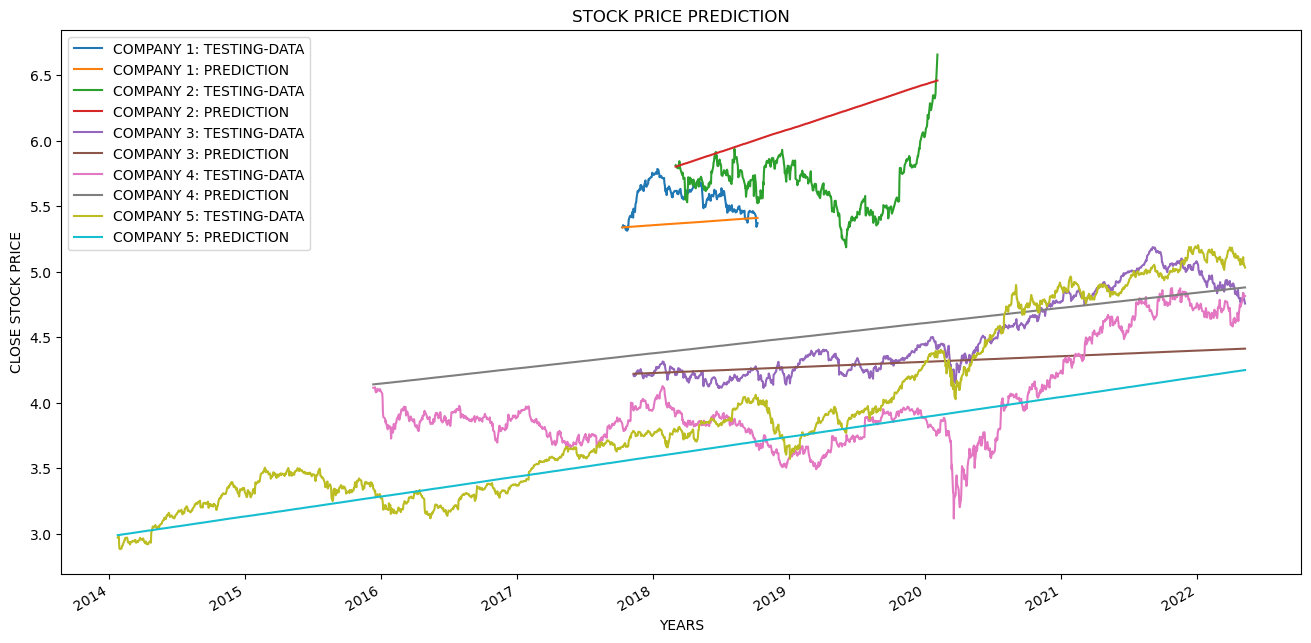

In [43]:
plt.figure(figsize=(16,8), dpi=100)
info_graph('NSE-TATAGLOBAL11.csv', 0, 1, 0, 1)
info_graph('TSLA.csv', 0, 1, 0, 2)
info_graph('A.csv', 1, 1, 1, 3)
info_graph('AN.csv', 0, 1, 0, 4)
info_graph('AAPL.csv', 1, 1, 3, 5)
plt.title('STOCK PRICE PREDICTION')
plt.xlabel('YEARS')
plt.ylabel('CLOSE STOCK PRICE')
plt.legend()